In [42]:
# Install required packages
!pip install -q torch torchvision opencv-python-headless scikit-learn matplotlib tqdm pillow gdown

In [ ]:
# =============================================================================
# Cell 0: Setup, Mount Drive, and Auto-Download Data
# =============================================================================

#If not running in Google Colab, please skip this cell and move to Cell 1.

import os
import sys
import gdown
import zipfile

from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Forgery Detection Project/data'

if os.path.exists(data_path):
    print(f"Data folder found at: {data_path}")
    print(f"Contents: {os.listdir(data_path)}")
else:
    print(f"Data folder not found at: {data_path}")
    print("\nAttempting to download dataset from Google Drive...")

    FILE_ID = "1wbZq32hCfPnP6FQibyGWLNdzoizPwEZ5"
    #If download fails, which is a regular occurance with large datasets, download manually from: https://drive.google.com/drive/folders/1LFRwF5AkJqSZOgXgGL1Ure9hKbMuJ8EN?usp=drive_link
    DOWNLOAD_URL = f"https://drive.google.com/uc?id={FILE_ID}"

    try:
        os.makedirs('/content/data', exist_ok=True)
        zip_path = '/content/data.zip'

        print("Downloading... (may take 5-10 minutes for large datasets)")
        gdown.download(DOWNLOAD_URL, zip_path, quiet=False)

        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('/content/')

        os.remove(zip_path)

        # Update data_path
        data_path = '/content/data'
        print(f"Dataset ready at: {data_path}")
        print(f"Contents: {os.listdir(data_path)}")

    except Exception as e:
        print(f"Download failed: {e}")
        print("\n" + "="*70)
        print("MANUAL SETUP REQUIRED")
        print("="*70)
        print("1. Download data from: https://drive.google.com/drive/folders/1LFRwF5AkJqSZOgXgGL1Ure9hKbMuJ8EN")
        print("2. Upload to: My Drive/Forgery Detection Project/data/")
        print("3. Folder structure must be:")
        print("   data/")
        print("     ├── Tp/")
        print("     └── CASIA 2 Groundtruth/")
        print("4. Re-run this cell")
        print("="*70)
        sys.exit(1)

ModuleNotFoundError: No module named 'google'

In [43]:
# =============================================================================
# Cell 1: Imports and Setup
# =============================================================================
import os
import sys
import io
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
import random
from typing import Dict, List, Tuple

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

# Global settings
CONFIG = {
    'data_path': '../data/CASIA2',
    'batch_size': 8,
    'image_size': (256, 256),
    'num_epochs': 100,
    'learning_rate': 3e-4,
    'num_workers': 2 if DEVICE == 'cuda' else 0,
    'seed': 42
}

# Set seeds for reproducibility
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])

print("\nConfiguration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Using device: cuda
PyTorch version: 2.5.1

Configuration:
  data_path: ../data/CASIA2
  batch_size: 8
  image_size: (256, 256)
  num_epochs: 100
  learning_rate: 0.0003
  num_workers: 2
  seed: 42


In [44]:
# =============================================================================
# Cell 2: Model Architecture Components
# =============================================================================

class DoubleConv(nn.Module):
    """Basic double convolution block"""
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, dropout)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Pad if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class SimpleUNet(nn.Module):
    """Lightweight U-Net - FIXED CHANNELS"""
    def __init__(self, n_channels=4, n_classes=1, dropout=0.15):
        super().__init__()
        
        # Encoder
        self.inc = DoubleConv(n_channels, 64, dropout)
        self.down1 = Down(64, 128, dropout)
        self.down2 = Down(128, 256, dropout)
        self.down3 = Down(256, 512, dropout)
        
        # Bottleneck - produces 1024 channels
        self.down4 = Down(512, 1024, dropout)
        
        # Decoder - now channels match
        self.up1 = Up(1024, 512, dropout)  # 1024 -> 512
        self.up2 = Up(512, 256, dropout)   # 512 -> 256
        self.up3 = Up(256, 128, dropout)   # 256 -> 128
        self.up4 = Up(128, 64, dropout)    # 128 -> 64
        
        self.outc = nn.Conv2d(64, n_classes, 1)
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128 channels
        x3 = self.down2(x2)   # 256 channels
        x4 = self.down3(x3)   # 512 channels
        x5 = self.down4(x4)   # 1024 channels (bottleneck)
        
        # Decoder
        x = self.up1(x5, x4)  # 1024 + 512 -> 512
        x = self.up2(x, x3)   # 512 + 256 -> 256
        x = self.up3(x, x2)   # 256 + 128 -> 128
        x = self.up4(x, x1)   # 128 + 64 -> 64
        
        return self.outc(x)   # 64 -> 1

In [45]:
# =============================================================================
# Cell 3: Loss Functions
# =============================================================================

class TverskyLoss(nn.Module):
    """Tversky loss for handling class imbalance"""
    def __init__(self, alpha=0.7, beta=0.3, smooth=1e-5):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        tp = (inputs * targets).sum()
        fp = (inputs * (1 - targets)).sum()
        fn = ((1 - inputs) * targets).sum()
        
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky

class DiceLoss(nn.Module):
    """Dice Loss"""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined loss function"""
    def __init__(self, bce_weight=0.2, dice_weight=0.4, tversky_weight=0.4):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.tversky_weight = tversky_weight
        
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.tversky = TverskyLoss(alpha=0.7, beta=0.3)
    
    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        tversky_loss = self.tversky(inputs, targets)
        
        total = (self.bce_weight * bce_loss + 
                self.dice_weight * dice_loss + 
                self.tversky_weight * tversky_loss)
        
        return total, {
            'bce': bce_loss.item(),
            'dice': dice_loss.item(),
            'tversky': tversky_loss.item(),
            'total': total.item()
        }

In [46]:
# =============================================================================
# Cell 4: Data Loading and ELA Generation
# =============================================================================

def generate_ela(image, quality=90, scale=15):
    """Generate Error Level Analysis"""
    if isinstance(image, np.ndarray):
        pil_image = Image.fromarray(image.astype(np.uint8))
    else:
        pil_image = image
    
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')
    
    buffer = io.BytesIO()
    pil_image.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    compressed = Image.open(buffer)
    
    original_np = np.array(pil_image, dtype=np.float32)
    compressed_np = np.array(compressed, dtype=np.float32)
    
    diff = np.abs(original_np - compressed_np)
    ela = np.clip(diff * scale, 0, 255).astype(np.uint8)
    ela_gray = cv2.cvtColor(ela, cv2.COLOR_RGB2GRAY)
    
    return ela_gray

class ForgeryDataset(Dataset):
    """Dataset for forgery detection"""
    def __init__(self, root_dir, image_size=(256, 256), train=True):
        self.root_dir = root_dir
        self.image_size = image_size
        self.train = train
        
        self.tampered_path = os.path.join(root_dir, 'Tp')
        self.groundtruth_path = os.path.join(root_dir, 'CASIA 2 Groundtruth')
        
        self.pairs = self._find_pairs()
        
        self.normalize_mean = np.array([0.485, 0.456, 0.406])
        self.normalize_std = np.array([0.229, 0.224, 0.225])
    
    def _find_pairs(self):
        pairs = []
        
        if not os.path.exists(self.tampered_path):
            return pairs
        
        if not os.path.exists(self.groundtruth_path):
            return pairs
        
        for img_file in os.listdir(self.tampered_path):
            if img_file.endswith(('.jpg', '.tif', '.bmp', '.png')):
                base_name = os.path.splitext(img_file)[0]
                mask_name = base_name + '_gt.png'
                mask_path = os.path.join(self.groundtruth_path, mask_name)
                
                if os.path.exists(mask_path):
                    img_path = os.path.join(self.tampered_path, img_file)
                    pairs.append((img_path, mask_path))
        
        return pairs
    
    def __len__(self):
        return len(self.pairs) if self.pairs else 100  # Fallback for demo
    
    def __getitem__(self, idx):
        if not self.pairs:
            # Generate synthetic data if no real data available
            image = np.random.randint(0, 255, (*self.image_size, 3), dtype=np.uint8)
            mask = np.random.binomial(1, 0.2, self.image_size).astype(np.float32)
            ela = np.random.randint(0, 100, self.image_size, dtype=np.uint8)
        else:
            img_path, mask_path = self.pairs[idx]
            
            image = cv2.imread(img_path)
            if image is None:
                return self.__getitem__(random.randint(0, len(self) - 1))
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, 0)
            
            if mask is None:
                return self.__getitem__(random.randint(0, len(self) - 1))
            
            ela = generate_ela(image)
            
            # Resize
            image = cv2.resize(image, self.image_size)
            mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
            ela = cv2.resize(ela, self.image_size)
            
            # Augmentation for training
            if self.train and random.random() > 0.5:
                image = cv2.flip(image, 1)
                mask = cv2.flip(mask, 1)
                ela = cv2.flip(ela, 1)
        
        # Normalize and convert to tensors
        image = image.astype(np.float32) / 255.0
        ela = ela.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        
        image = (image - self.normalize_mean) / self.normalize_std
        
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        ela = torch.from_numpy(ela).unsqueeze(0).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        combined = torch.cat([image, ela], dim=0)
        mask = (mask > 0.5).float()
        
        return combined, mask

In [47]:
# =============================================================================
# Cell 5: Training Functinons
# =============================================================================

def calculate_metrics(predictions, targets, threshold=0.5):
    """Calculate evaluation metrics"""
    preds_binary = (predictions > threshold).float()
    targets_binary = (targets > 0.5).float()
    
    preds_flat = preds_binary.view(-1)
    targets_flat = targets_binary.view(-1)
    
    tp = (preds_flat * targets_flat).sum().item()
    fp = (preds_flat * (1 - targets_flat)).sum().item()
    fn = ((1 - preds_flat) * targets_flat).sum().item()
    tn = ((1 - preds_flat) * (1 - targets_flat)).sum().item()
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    iou = tp / (tp + fp + fn + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'iou': iou,
        'accuracy': accuracy
    }

In [48]:
# =============================================================================
# Cell 6: Create Data Loaders
# =============================================================================

# Create dataset
dataset = ForgeryDataset(CONFIG['data_path'], CONFIG['image_size'], train=True)
val_dataset = ForgeryDataset(CONFIG['data_path'], CONFIG['image_size'], train=False)

# Split dataset
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

indices = list(range(total_size))
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

train_subset = Subset(dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)
test_subset = Subset(val_dataset, test_indices)

# Create loaders
train_loader = DataLoader(train_subset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_subset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"Dataset sizes:")
print(f"  Train: {len(train_subset)}")
print(f"  Val: {len(val_subset)}")
print(f"  Test: {len(test_subset)}")

Dataset sizes:
  Train: 3486
  Val: 747
  Test: 748


In [49]:
# =============================================================================
# Cell 7: Initialise Model
# =============================================================================

model = SimpleUNet(n_channels=4, n_classes=1, dropout=0.15).to(DEVICE)
criterion = CombinedLoss(bce_weight=0.2, dice_weight=0.4, tversky_weight=0.4)
optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel initialised:")
print(f"  Total parameters: {total_params:,}")
print(f"  Device: {DEVICE}")

# Memory check for CUDA
if torch.cuda.is_available():
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")


Model initialised:
  Total parameters: 31,038,209
  Device: cuda
  GPU Memory: 17.17 GB
  GPU Name: NVIDIA GeForce RTX 4080


In [50]:
# =============================================================================
# Cell 8: Training Loop
# =============================================================================

DEMO_MODE = False  # Set to False for full training
num_epochs = 3 if DEMO_MODE else CONFIG['num_epochs']

print(f"\n{'='*70}")
print("ENSEMBLE TRAINING - 3 Models with Different Seeds")
print(f"{'='*70}\n")

ensemble_models = []
ensemble_histories = []

for model_idx, seed in enumerate([42, 123, 456]):
    print(f"\n{'='*70}")
    print(f"Training Model {model_idx + 1}/3 (Seed: {seed})")
    print(f"{'='*70}\n")
    
    # Set seed for this model
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Create fresh model
    model = SimpleUNet(n_channels=4, n_classes=1, dropout=0.15).to(DEVICE)
    criterion = CombinedLoss(bce_weight=0.2, dice_weight=0.4, tversky_weight=0.4)
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
    
    best_val_iou = 0
    history = {'train_loss': [], 'val_loss': [], 'val_iou': []}
    
    # Training loop for this model
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        loop = tqdm(train_loader, desc=f"Model {model_idx+1} - Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (data, targets) in enumerate(loop):
            data, targets = data.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss, _ = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
            if DEMO_MODE and batch_idx >= 5:
                break
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_ious = []
        
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(val_loader):
                data, targets = data.to(DEVICE), targets.to(DEVICE)
                outputs = model(data)
                loss, _ = criterion(outputs, targets)
                val_loss += loss.item()
                
                preds = torch.sigmoid(outputs)
                metrics = calculate_metrics(preds, targets)
                val_ious.append(metrics['iou'])
                
                if DEMO_MODE and batch_idx >= 3:
                    break
        
        avg_train_loss = train_loss / min(len(train_loader), 6 if DEMO_MODE else len(train_loader))
        avg_val_loss = val_loss / min(len(val_loader), 4 if DEMO_MODE else len(val_loader))
        avg_val_iou = np.mean(val_ious)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_iou'].append(avg_val_iou)
        
        print(f"  Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val IoU={avg_val_iou:.4f}")
        
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), f'best_model_{model_idx+1}.pth')
    
    print(f"\nModel {model_idx+1} complete! Best IoU: {best_val_iou:.4f}")
    
    # Load best checkpoint for this model
    model.load_state_dict(torch.load(f'best_model_{model_idx+1}.pth', map_location=DEVICE))
    
    ensemble_models.append(model)
    ensemble_histories.append(history)

print(f"\n{'='*70}")
print("ENSEMBLE TRAINING COMPLETE")
print(f"{'='*70}")
print("\nIndividual model best IoUs:")
for i, hist in enumerate(ensemble_histories):
    print(f"  Model {i+1}: {max(hist['val_iou']):.4f}")


ENSEMBLE TRAINING - 3 Models with Different Seeds


Training Model 1/3 (Seed: 42)



Model 1 - Epoch 1/100: 100%|██████████| 436/436 [01:46<00:00,  4.11it/s, loss=0.677]


  Epoch 1: Train Loss=0.7449, Val Loss=0.7085, Val IoU=0.1434


Model 1 - Epoch 2/100: 100%|██████████| 436/436 [01:40<00:00,  4.36it/s, loss=0.786]


  Epoch 2: Train Loss=0.6796, Val Loss=0.6354, Val IoU=0.2083


Model 1 - Epoch 3/100: 100%|██████████| 436/436 [01:40<00:00,  4.32it/s, loss=0.412]


  Epoch 3: Train Loss=0.6314, Val Loss=0.6093, Val IoU=0.2241


Model 1 - Epoch 4/100: 100%|██████████| 436/436 [01:39<00:00,  4.36it/s, loss=0.396]


  Epoch 4: Train Loss=0.5975, Val Loss=0.5770, Val IoU=0.2486


Model 1 - Epoch 5/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.585]


  Epoch 5: Train Loss=0.5868, Val Loss=0.5770, Val IoU=0.2548


Model 1 - Epoch 6/100: 100%|██████████| 436/436 [01:40<00:00,  4.35it/s, loss=0.571]


  Epoch 6: Train Loss=0.5618, Val Loss=0.5535, Val IoU=0.2708


Model 1 - Epoch 7/100: 100%|██████████| 436/436 [01:37<00:00,  4.45it/s, loss=0.699]


  Epoch 7: Train Loss=0.5481, Val Loss=0.5453, Val IoU=0.2830


Model 1 - Epoch 8/100: 100%|██████████| 436/436 [01:39<00:00,  4.36it/s, loss=0.798]


  Epoch 8: Train Loss=0.5266, Val Loss=0.4757, Val IoU=0.3395


Model 1 - Epoch 9/100: 100%|██████████| 436/436 [01:40<00:00,  4.34it/s, loss=0.37] 


  Epoch 9: Train Loss=0.5229, Val Loss=0.4913, Val IoU=0.3220


Model 1 - Epoch 10/100: 100%|██████████| 436/436 [01:37<00:00,  4.45it/s, loss=0.541]


  Epoch 10: Train Loss=0.5104, Val Loss=0.4530, Val IoU=0.3687


Model 1 - Epoch 11/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.383]


  Epoch 11: Train Loss=0.4963, Val Loss=0.4602, Val IoU=0.3629


Model 1 - Epoch 12/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.403]


  Epoch 12: Train Loss=0.4792, Val Loss=0.4277, Val IoU=0.3919


Model 1 - Epoch 13/100: 100%|██████████| 436/436 [01:41<00:00,  4.29it/s, loss=0.268]


  Epoch 13: Train Loss=0.4782, Val Loss=0.4284, Val IoU=0.3912


Model 1 - Epoch 14/100: 100%|██████████| 436/436 [01:41<00:00,  4.30it/s, loss=0.622] 


  Epoch 14: Train Loss=0.4695, Val Loss=0.4384, Val IoU=0.3885


Model 1 - Epoch 15/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.155]


  Epoch 15: Train Loss=0.4604, Val Loss=0.4547, Val IoU=0.3642


Model 1 - Epoch 16/100: 100%|██████████| 436/436 [01:42<00:00,  4.24it/s, loss=0.763]


  Epoch 16: Train Loss=0.4519, Val Loss=0.4136, Val IoU=0.4017


Model 1 - Epoch 17/100: 100%|██████████| 436/436 [01:41<00:00,  4.31it/s, loss=0.176]


  Epoch 17: Train Loss=0.4403, Val Loss=0.4231, Val IoU=0.4045


Model 1 - Epoch 18/100: 100%|██████████| 436/436 [01:42<00:00,  4.26it/s, loss=0.499]


  Epoch 18: Train Loss=0.4427, Val Loss=0.4742, Val IoU=0.3423


Model 1 - Epoch 19/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.345]


  Epoch 19: Train Loss=0.4344, Val Loss=0.4116, Val IoU=0.4030


Model 1 - Epoch 20/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.512]


  Epoch 20: Train Loss=0.4207, Val Loss=0.3953, Val IoU=0.4276


Model 1 - Epoch 21/100: 100%|██████████| 436/436 [01:40<00:00,  4.32it/s, loss=0.355]


  Epoch 21: Train Loss=0.4171, Val Loss=0.3715, Val IoU=0.4526


Model 1 - Epoch 22/100: 100%|██████████| 436/436 [01:39<00:00,  4.37it/s, loss=0.286] 


  Epoch 22: Train Loss=0.4242, Val Loss=0.3797, Val IoU=0.4433


Model 1 - Epoch 23/100: 100%|██████████| 436/436 [01:37<00:00,  4.49it/s, loss=0.172]


  Epoch 23: Train Loss=0.4122, Val Loss=0.3710, Val IoU=0.4521


Model 1 - Epoch 24/100: 100%|██████████| 436/436 [01:37<00:00,  4.49it/s, loss=0.23]  


  Epoch 24: Train Loss=0.4024, Val Loss=0.3669, Val IoU=0.4605


Model 1 - Epoch 25/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.193] 


  Epoch 25: Train Loss=0.3983, Val Loss=0.3959, Val IoU=0.4237


Model 1 - Epoch 26/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.184] 


  Epoch 26: Train Loss=0.3865, Val Loss=0.3618, Val IoU=0.4684


Model 1 - Epoch 27/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.339]


  Epoch 27: Train Loss=0.3846, Val Loss=0.4072, Val IoU=0.4108


Model 1 - Epoch 28/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.267] 


  Epoch 28: Train Loss=0.3984, Val Loss=0.3486, Val IoU=0.4776


Model 1 - Epoch 29/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.5]  


  Epoch 29: Train Loss=0.3843, Val Loss=0.3793, Val IoU=0.4523


Model 1 - Epoch 30/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.23]  


  Epoch 30: Train Loss=0.3832, Val Loss=0.3673, Val IoU=0.4590


Model 1 - Epoch 31/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.149] 


  Epoch 31: Train Loss=0.3670, Val Loss=0.3437, Val IoU=0.4836


Model 1 - Epoch 32/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.788] 


  Epoch 32: Train Loss=0.3723, Val Loss=0.3599, Val IoU=0.4781


Model 1 - Epoch 33/100: 100%|██████████| 436/436 [01:34<00:00,  4.59it/s, loss=0.653] 


  Epoch 33: Train Loss=0.3762, Val Loss=0.3374, Val IoU=0.5006


Model 1 - Epoch 34/100: 100%|██████████| 436/436 [01:34<00:00,  4.59it/s, loss=0.113] 


  Epoch 34: Train Loss=0.3629, Val Loss=0.3610, Val IoU=0.4668


Model 1 - Epoch 35/100: 100%|██████████| 436/436 [01:35<00:00,  4.57it/s, loss=0.622] 


  Epoch 35: Train Loss=0.3663, Val Loss=0.3660, Val IoU=0.4662


Model 1 - Epoch 36/100: 100%|██████████| 436/436 [01:34<00:00,  4.59it/s, loss=0.213] 


  Epoch 36: Train Loss=0.3573, Val Loss=0.3269, Val IoU=0.5136


Model 1 - Epoch 37/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.486] 


  Epoch 37: Train Loss=0.3536, Val Loss=0.3623, Val IoU=0.4556


Model 1 - Epoch 38/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.858] 


  Epoch 38: Train Loss=0.3527, Val Loss=0.3061, Val IoU=0.5381


Model 1 - Epoch 39/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.434] 


  Epoch 39: Train Loss=0.3569, Val Loss=0.3207, Val IoU=0.5116


Model 1 - Epoch 40/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.681] 


  Epoch 40: Train Loss=0.3411, Val Loss=0.3254, Val IoU=0.5178


Model 1 - Epoch 41/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.69]  


  Epoch 41: Train Loss=0.3389, Val Loss=0.3325, Val IoU=0.4950


Model 1 - Epoch 42/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.16]  


  Epoch 42: Train Loss=0.3446, Val Loss=0.3204, Val IoU=0.5096


Model 1 - Epoch 43/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.32]  


  Epoch 43: Train Loss=0.3395, Val Loss=0.3120, Val IoU=0.5300


Model 1 - Epoch 44/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.325] 


  Epoch 44: Train Loss=0.3318, Val Loss=0.3117, Val IoU=0.5188


Model 1 - Epoch 45/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.136] 


  Epoch 45: Train Loss=0.3301, Val Loss=0.3528, Val IoU=0.4659


Model 1 - Epoch 46/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.225] 


  Epoch 46: Train Loss=0.3289, Val Loss=0.3257, Val IoU=0.5017


Model 1 - Epoch 47/100: 100%|██████████| 436/436 [01:34<00:00,  4.59it/s, loss=0.204] 


  Epoch 47: Train Loss=0.3310, Val Loss=0.3094, Val IoU=0.5240


Model 1 - Epoch 48/100: 100%|██████████| 436/436 [01:35<00:00,  4.56it/s, loss=0.35]  


  Epoch 48: Train Loss=0.3171, Val Loss=0.3102, Val IoU=0.5422


Model 1 - Epoch 49/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.0959]


  Epoch 49: Train Loss=0.3178, Val Loss=0.3080, Val IoU=0.5204


Model 1 - Epoch 50/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.196] 


  Epoch 50: Train Loss=0.3235, Val Loss=0.3104, Val IoU=0.5259


Model 1 - Epoch 51/100: 100%|██████████| 436/436 [01:33<00:00,  4.65it/s, loss=0.613] 


  Epoch 51: Train Loss=0.3165, Val Loss=0.3189, Val IoU=0.5117


Model 1 - Epoch 52/100: 100%|██████████| 436/436 [01:35<00:00,  4.59it/s, loss=0.508] 


  Epoch 52: Train Loss=0.3228, Val Loss=0.3133, Val IoU=0.5158


Model 1 - Epoch 53/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.643] 


  Epoch 53: Train Loss=0.3149, Val Loss=0.3475, Val IoU=0.4982


Model 1 - Epoch 54/100: 100%|██████████| 436/436 [01:33<00:00,  4.66it/s, loss=0.232] 


  Epoch 54: Train Loss=0.3093, Val Loss=0.2974, Val IoU=0.5443


Model 1 - Epoch 55/100: 100%|██████████| 436/436 [01:34<00:00,  4.59it/s, loss=0.395] 


  Epoch 55: Train Loss=0.3082, Val Loss=0.2951, Val IoU=0.5417


Model 1 - Epoch 56/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.242] 


  Epoch 56: Train Loss=0.2958, Val Loss=0.3142, Val IoU=0.5306


Model 1 - Epoch 57/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.14]  


  Epoch 57: Train Loss=0.3055, Val Loss=0.3355, Val IoU=0.5015


Model 1 - Epoch 58/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.434] 


  Epoch 58: Train Loss=0.2989, Val Loss=0.3106, Val IoU=0.5280


Model 1 - Epoch 59/100: 100%|██████████| 436/436 [01:35<00:00,  4.59it/s, loss=0.284] 


  Epoch 59: Train Loss=0.2926, Val Loss=0.2994, Val IoU=0.5474


Model 1 - Epoch 60/100: 100%|██████████| 436/436 [01:34<00:00,  4.59it/s, loss=0.105] 


  Epoch 60: Train Loss=0.3095, Val Loss=0.2838, Val IoU=0.5625


Model 1 - Epoch 61/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.252] 


  Epoch 61: Train Loss=0.2884, Val Loss=0.2833, Val IoU=0.5589


Model 1 - Epoch 62/100: 100%|██████████| 436/436 [01:35<00:00,  4.59it/s, loss=0.121] 


  Epoch 62: Train Loss=0.2822, Val Loss=0.2950, Val IoU=0.5454


Model 1 - Epoch 63/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.257] 


  Epoch 63: Train Loss=0.2948, Val Loss=0.2832, Val IoU=0.5595


Model 1 - Epoch 64/100: 100%|██████████| 436/436 [01:34<00:00,  4.64it/s, loss=0.309] 


  Epoch 64: Train Loss=0.2818, Val Loss=0.2834, Val IoU=0.5543


Model 1 - Epoch 65/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.452] 


  Epoch 65: Train Loss=0.2882, Val Loss=0.2782, Val IoU=0.5719


Model 1 - Epoch 66/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.0937]


  Epoch 66: Train Loss=0.2867, Val Loss=0.3175, Val IoU=0.5170


Model 1 - Epoch 67/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.486] 


  Epoch 67: Train Loss=0.2889, Val Loss=0.3418, Val IoU=0.4836


Model 1 - Epoch 68/100: 100%|██████████| 436/436 [01:37<00:00,  4.49it/s, loss=0.179] 


  Epoch 68: Train Loss=0.2737, Val Loss=0.2964, Val IoU=0.5541


Model 1 - Epoch 69/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.278] 


  Epoch 69: Train Loss=0.2857, Val Loss=0.2966, Val IoU=0.5354


Model 1 - Epoch 70/100: 100%|██████████| 436/436 [01:34<00:00,  4.59it/s, loss=0.238] 


  Epoch 70: Train Loss=0.2761, Val Loss=0.3323, Val IoU=0.4976


Model 1 - Epoch 71/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.396] 


  Epoch 71: Train Loss=0.2758, Val Loss=0.2987, Val IoU=0.5411


Model 1 - Epoch 72/100: 100%|██████████| 436/436 [01:35<00:00,  4.59it/s, loss=0.428] 


  Epoch 72: Train Loss=0.2730, Val Loss=0.3167, Val IoU=0.5174


Model 1 - Epoch 73/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.307] 


  Epoch 73: Train Loss=0.2702, Val Loss=0.2805, Val IoU=0.5571


Model 1 - Epoch 74/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.394] 


  Epoch 74: Train Loss=0.2790, Val Loss=0.3014, Val IoU=0.5304


Model 1 - Epoch 75/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.207] 


  Epoch 75: Train Loss=0.2767, Val Loss=0.2944, Val IoU=0.5582


Model 1 - Epoch 76/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.16]  


  Epoch 76: Train Loss=0.2737, Val Loss=0.2795, Val IoU=0.5713


Model 1 - Epoch 77/100: 100%|██████████| 436/436 [01:35<00:00,  4.59it/s, loss=0.126] 


  Epoch 77: Train Loss=0.2682, Val Loss=0.2588, Val IoU=0.5950


Model 1 - Epoch 78/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.459] 


  Epoch 78: Train Loss=0.2760, Val Loss=0.3019, Val IoU=0.5341


Model 1 - Epoch 79/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.216] 


  Epoch 79: Train Loss=0.2746, Val Loss=0.2798, Val IoU=0.5622


Model 1 - Epoch 80/100: 100%|██████████| 436/436 [01:34<00:00,  4.59it/s, loss=0.0749]


  Epoch 80: Train Loss=0.2592, Val Loss=0.2737, Val IoU=0.5686


Model 1 - Epoch 81/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.122] 


  Epoch 81: Train Loss=0.2722, Val Loss=0.2638, Val IoU=0.5927


Model 1 - Epoch 82/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.174] 


  Epoch 82: Train Loss=0.2599, Val Loss=0.2686, Val IoU=0.5778


Model 1 - Epoch 83/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.146] 


  Epoch 83: Train Loss=0.2576, Val Loss=0.2518, Val IoU=0.6139


Model 1 - Epoch 84/100: 100%|██████████| 436/436 [01:34<00:00,  4.64it/s, loss=0.131] 


  Epoch 84: Train Loss=0.2584, Val Loss=0.2618, Val IoU=0.5817


Model 1 - Epoch 85/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.231] 


  Epoch 85: Train Loss=0.2647, Val Loss=0.2634, Val IoU=0.5948


Model 1 - Epoch 86/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.374] 


  Epoch 86: Train Loss=0.2579, Val Loss=0.2598, Val IoU=0.5939


Model 1 - Epoch 87/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.267] 


  Epoch 87: Train Loss=0.2540, Val Loss=0.2707, Val IoU=0.5703


Model 1 - Epoch 88/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.129] 


  Epoch 88: Train Loss=0.2584, Val Loss=0.2672, Val IoU=0.5941


Model 1 - Epoch 89/100: 100%|██████████| 436/436 [01:35<00:00,  4.59it/s, loss=0.11]  


  Epoch 89: Train Loss=0.2559, Val Loss=0.2759, Val IoU=0.5813


Model 1 - Epoch 90/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.0945]


  Epoch 90: Train Loss=0.2381, Val Loss=0.2701, Val IoU=0.5716


Model 1 - Epoch 91/100: 100%|██████████| 436/436 [01:59<00:00,  3.66it/s, loss=0.301] 


  Epoch 91: Train Loss=0.2544, Val Loss=0.2817, Val IoU=0.5589


Model 1 - Epoch 92/100: 100%|██████████| 436/436 [01:49<00:00,  4.00it/s, loss=0.124] 


  Epoch 92: Train Loss=0.2550, Val Loss=0.2544, Val IoU=0.5944


Model 1 - Epoch 93/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.215] 


  Epoch 93: Train Loss=0.2434, Val Loss=0.2809, Val IoU=0.5571


Model 1 - Epoch 94/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.142] 


  Epoch 94: Train Loss=0.2480, Val Loss=0.2624, Val IoU=0.5943


Model 1 - Epoch 95/100: 100%|██████████| 436/436 [01:33<00:00,  4.66it/s, loss=0.214] 


  Epoch 95: Train Loss=0.2483, Val Loss=0.2620, Val IoU=0.5851


Model 1 - Epoch 96/100: 100%|██████████| 436/436 [01:33<00:00,  4.68it/s, loss=0.301] 


  Epoch 96: Train Loss=0.2486, Val Loss=0.2706, Val IoU=0.5693


Model 1 - Epoch 97/100: 100%|██████████| 436/436 [01:33<00:00,  4.65it/s, loss=0.104] 


  Epoch 97: Train Loss=0.2444, Val Loss=0.2674, Val IoU=0.5877


Model 1 - Epoch 98/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.265] 


  Epoch 98: Train Loss=0.2364, Val Loss=0.2553, Val IoU=0.5996


Model 1 - Epoch 99/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.0873]


  Epoch 99: Train Loss=0.2439, Val Loss=0.2941, Val IoU=0.5691


Model 1 - Epoch 100/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.0698]


  Epoch 100: Train Loss=0.2387, Val Loss=0.2620, Val IoU=0.5934

Model 1 complete! Best IoU: 0.6139

Training Model 2/3 (Seed: 123)



Model 2 - Epoch 1/100: 100%|██████████| 436/436 [01:31<00:00,  4.76it/s, loss=0.814]


  Epoch 1: Train Loss=0.7408, Val Loss=0.6814, Val IoU=0.1883


Model 2 - Epoch 2/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.739]


  Epoch 2: Train Loss=0.6877, Val Loss=0.6500, Val IoU=0.2042


Model 2 - Epoch 3/100: 100%|██████████| 436/436 [01:32<00:00,  4.71it/s, loss=0.646]


  Epoch 3: Train Loss=0.6521, Val Loss=0.6248, Val IoU=0.2176


Model 2 - Epoch 4/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.421]


  Epoch 4: Train Loss=0.6090, Val Loss=0.5791, Val IoU=0.2501


Model 2 - Epoch 5/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.832]


  Epoch 5: Train Loss=0.5813, Val Loss=0.5826, Val IoU=0.2336


Model 2 - Epoch 6/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.724]


  Epoch 6: Train Loss=0.5609, Val Loss=0.5273, Val IoU=0.2981


Model 2 - Epoch 7/100: 100%|██████████| 436/436 [01:34<00:00,  4.59it/s, loss=0.629]


  Epoch 7: Train Loss=0.5469, Val Loss=0.5252, Val IoU=0.2881


Model 2 - Epoch 8/100: 100%|██████████| 436/436 [01:30<00:00,  4.79it/s, loss=0.57] 


  Epoch 8: Train Loss=0.5377, Val Loss=0.5168, Val IoU=0.3194


Model 2 - Epoch 9/100: 100%|██████████| 436/436 [01:32<00:00,  4.74it/s, loss=0.521]


  Epoch 9: Train Loss=0.5203, Val Loss=0.4782, Val IoU=0.3390


Model 2 - Epoch 10/100: 100%|██████████| 436/436 [01:33<00:00,  4.67it/s, loss=0.586]


  Epoch 10: Train Loss=0.5008, Val Loss=0.5195, Val IoU=0.2905


Model 2 - Epoch 11/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.556]


  Epoch 11: Train Loss=0.4929, Val Loss=0.4325, Val IoU=0.3927


Model 2 - Epoch 12/100: 100%|██████████| 436/436 [01:33<00:00,  4.65it/s, loss=0.55] 


  Epoch 12: Train Loss=0.4771, Val Loss=0.4102, Val IoU=0.4143


Model 2 - Epoch 13/100: 100%|██████████| 436/436 [01:32<00:00,  4.71it/s, loss=0.319]


  Epoch 13: Train Loss=0.4684, Val Loss=0.4270, Val IoU=0.3957


Model 2 - Epoch 14/100: 100%|██████████| 436/436 [01:32<00:00,  4.71it/s, loss=0.31] 


  Epoch 14: Train Loss=0.4616, Val Loss=0.4401, Val IoU=0.3742


Model 2 - Epoch 15/100: 100%|██████████| 436/436 [01:32<00:00,  4.73it/s, loss=0.415]


  Epoch 15: Train Loss=0.4523, Val Loss=0.4037, Val IoU=0.4240


Model 2 - Epoch 16/100: 100%|██████████| 436/436 [01:30<00:00,  4.79it/s, loss=0.338]


  Epoch 16: Train Loss=0.4288, Val Loss=0.3849, Val IoU=0.4462


Model 2 - Epoch 17/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.149]


  Epoch 17: Train Loss=0.4369, Val Loss=0.3797, Val IoU=0.4515


Model 2 - Epoch 18/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.425]


  Epoch 18: Train Loss=0.4231, Val Loss=0.4537, Val IoU=0.3620


Model 2 - Epoch 19/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.564]


  Epoch 19: Train Loss=0.4271, Val Loss=0.3734, Val IoU=0.4589


Model 2 - Epoch 20/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.232]


  Epoch 20: Train Loss=0.4018, Val Loss=0.3694, Val IoU=0.4535


Model 2 - Epoch 21/100: 100%|██████████| 436/436 [01:32<00:00,  4.73it/s, loss=0.63]  


  Epoch 21: Train Loss=0.4084, Val Loss=0.3649, Val IoU=0.4645


Model 2 - Epoch 22/100: 100%|██████████| 436/436 [02:02<00:00,  3.56it/s, loss=0.259] 


  Epoch 22: Train Loss=0.4024, Val Loss=0.4252, Val IoU=0.4011


Model 2 - Epoch 23/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.537] 


  Epoch 23: Train Loss=0.3965, Val Loss=0.3526, Val IoU=0.4733


Model 2 - Epoch 24/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.438]


  Epoch 24: Train Loss=0.3985, Val Loss=0.3807, Val IoU=0.4495


Model 2 - Epoch 25/100: 100%|██████████| 436/436 [01:30<00:00,  4.84it/s, loss=0.206]


  Epoch 25: Train Loss=0.3940, Val Loss=0.3469, Val IoU=0.4788


Model 2 - Epoch 26/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.328] 


  Epoch 26: Train Loss=0.3837, Val Loss=0.3619, Val IoU=0.4578


Model 2 - Epoch 27/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.165] 


  Epoch 27: Train Loss=0.3756, Val Loss=0.3655, Val IoU=0.4570


Model 2 - Epoch 28/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.316] 


  Epoch 28: Train Loss=0.3742, Val Loss=0.3235, Val IoU=0.5066


Model 2 - Epoch 29/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.402] 


  Epoch 29: Train Loss=0.3677, Val Loss=0.3547, Val IoU=0.4630


Model 2 - Epoch 30/100: 100%|██████████| 436/436 [01:32<00:00,  4.72it/s, loss=0.256] 


  Epoch 30: Train Loss=0.3718, Val Loss=0.3251, Val IoU=0.5106


Model 2 - Epoch 31/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.49]  


  Epoch 31: Train Loss=0.3672, Val Loss=0.3755, Val IoU=0.4752


Model 2 - Epoch 32/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.165] 


  Epoch 32: Train Loss=0.3533, Val Loss=0.3322, Val IoU=0.4974


Model 2 - Epoch 33/100: 100%|██████████| 436/436 [01:33<00:00,  4.67it/s, loss=0.393] 


  Epoch 33: Train Loss=0.3617, Val Loss=0.3146, Val IoU=0.5219


Model 2 - Epoch 34/100: 100%|██████████| 436/436 [01:31<00:00,  4.79it/s, loss=0.302] 


  Epoch 34: Train Loss=0.3571, Val Loss=0.3098, Val IoU=0.5329


Model 2 - Epoch 35/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.23]  


  Epoch 35: Train Loss=0.3617, Val Loss=0.3190, Val IoU=0.5086


Model 2 - Epoch 36/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.246] 


  Epoch 36: Train Loss=0.3467, Val Loss=0.3134, Val IoU=0.5231


Model 2 - Epoch 37/100: 100%|██████████| 436/436 [01:33<00:00,  4.65it/s, loss=0.381] 


  Epoch 37: Train Loss=0.3409, Val Loss=0.3266, Val IoU=0.5011


Model 2 - Epoch 38/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.171] 


  Epoch 38: Train Loss=0.3388, Val Loss=0.3224, Val IoU=0.5034


Model 2 - Epoch 39/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.17]  


  Epoch 39: Train Loss=0.3391, Val Loss=0.2982, Val IoU=0.5372


Model 2 - Epoch 40/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.0698]


  Epoch 40: Train Loss=0.3384, Val Loss=0.3103, Val IoU=0.5208


Model 2 - Epoch 41/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.643] 


  Epoch 41: Train Loss=0.3275, Val Loss=0.2971, Val IoU=0.5447


Model 2 - Epoch 42/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.565] 


  Epoch 42: Train Loss=0.3295, Val Loss=0.2996, Val IoU=0.5442


Model 2 - Epoch 43/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.719] 


  Epoch 43: Train Loss=0.3220, Val Loss=0.3228, Val IoU=0.5113


Model 2 - Epoch 44/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.178] 


  Epoch 44: Train Loss=0.3194, Val Loss=0.3107, Val IoU=0.5307


Model 2 - Epoch 45/100: 100%|██████████| 436/436 [01:34<00:00,  4.64it/s, loss=0.563] 


  Epoch 45: Train Loss=0.3242, Val Loss=0.3060, Val IoU=0.5297


Model 2 - Epoch 46/100: 100%|██████████| 436/436 [01:34<00:00,  4.64it/s, loss=0.407] 


  Epoch 46: Train Loss=0.3058, Val Loss=0.3025, Val IoU=0.5320


Model 2 - Epoch 47/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.415] 


  Epoch 47: Train Loss=0.3150, Val Loss=0.2996, Val IoU=0.5351


Model 2 - Epoch 48/100: 100%|██████████| 436/436 [01:31<00:00,  4.77it/s, loss=0.587] 


  Epoch 48: Train Loss=0.3168, Val Loss=0.2889, Val IoU=0.5521


Model 2 - Epoch 49/100: 100%|██████████| 436/436 [01:31<00:00,  4.77it/s, loss=0.404] 


  Epoch 49: Train Loss=0.3083, Val Loss=0.2974, Val IoU=0.5395


Model 2 - Epoch 50/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.392] 


  Epoch 50: Train Loss=0.3122, Val Loss=0.2896, Val IoU=0.5482


Model 2 - Epoch 51/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.595] 


  Epoch 51: Train Loss=0.3117, Val Loss=0.2922, Val IoU=0.5513


Model 2 - Epoch 52/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.346] 


  Epoch 52: Train Loss=0.3068, Val Loss=0.2872, Val IoU=0.5504


Model 2 - Epoch 53/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.248] 


  Epoch 53: Train Loss=0.3106, Val Loss=0.2950, Val IoU=0.5391


Model 2 - Epoch 54/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.717] 


  Epoch 54: Train Loss=0.2982, Val Loss=0.2945, Val IoU=0.5488


Model 2 - Epoch 55/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.16]  


  Epoch 55: Train Loss=0.2962, Val Loss=0.3054, Val IoU=0.5301


Model 2 - Epoch 56/100: 100%|██████████| 436/436 [01:30<00:00,  4.84it/s, loss=0.642] 


  Epoch 56: Train Loss=0.3016, Val Loss=0.2965, Val IoU=0.5349


Model 2 - Epoch 57/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.207] 


  Epoch 57: Train Loss=0.2967, Val Loss=0.2941, Val IoU=0.5447


Model 2 - Epoch 58/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.257] 


  Epoch 58: Train Loss=0.2950, Val Loss=0.2755, Val IoU=0.5653


Model 2 - Epoch 59/100: 100%|██████████| 436/436 [01:29<00:00,  4.85it/s, loss=0.165] 


  Epoch 59: Train Loss=0.2934, Val Loss=0.3014, Val IoU=0.5318


Model 2 - Epoch 60/100: 100%|██████████| 436/436 [01:29<00:00,  4.85it/s, loss=0.297] 


  Epoch 60: Train Loss=0.2931, Val Loss=0.2801, Val IoU=0.5606


Model 2 - Epoch 61/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.754] 


  Epoch 61: Train Loss=0.2900, Val Loss=0.3415, Val IoU=0.4796


Model 2 - Epoch 62/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.17]  


  Epoch 62: Train Loss=0.2883, Val Loss=0.3113, Val IoU=0.5485


Model 2 - Epoch 63/100: 100%|██████████| 436/436 [01:29<00:00,  4.85it/s, loss=0.157] 


  Epoch 63: Train Loss=0.2787, Val Loss=0.2787, Val IoU=0.5653


Model 2 - Epoch 64/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.295] 


  Epoch 64: Train Loss=0.2718, Val Loss=0.2877, Val IoU=0.5497


Model 2 - Epoch 65/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.501] 


  Epoch 65: Train Loss=0.2753, Val Loss=0.2840, Val IoU=0.5584


Model 2 - Epoch 66/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.229] 


  Epoch 66: Train Loss=0.2698, Val Loss=0.2927, Val IoU=0.5470


Model 2 - Epoch 67/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.169] 


  Epoch 67: Train Loss=0.2868, Val Loss=0.2799, Val IoU=0.5769


Model 2 - Epoch 68/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.293] 


  Epoch 68: Train Loss=0.2811, Val Loss=0.2957, Val IoU=0.5480


Model 2 - Epoch 69/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.0855]


  Epoch 69: Train Loss=0.2845, Val Loss=0.2784, Val IoU=0.5724


Model 2 - Epoch 70/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.116] 


  Epoch 70: Train Loss=0.2690, Val Loss=0.2949, Val IoU=0.5408


Model 2 - Epoch 71/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.068] 


  Epoch 71: Train Loss=0.2734, Val Loss=0.2810, Val IoU=0.5656


Model 2 - Epoch 72/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.348] 


  Epoch 72: Train Loss=0.2619, Val Loss=0.3000, Val IoU=0.5576


Model 2 - Epoch 73/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.0758]


  Epoch 73: Train Loss=0.2722, Val Loss=0.2685, Val IoU=0.5787


Model 2 - Epoch 74/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.14]  


  Epoch 74: Train Loss=0.2637, Val Loss=0.2722, Val IoU=0.5709


Model 2 - Epoch 75/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.159] 


  Epoch 75: Train Loss=0.2640, Val Loss=0.2783, Val IoU=0.5664


Model 2 - Epoch 76/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.253] 


  Epoch 76: Train Loss=0.2725, Val Loss=0.2720, Val IoU=0.5702


Model 2 - Epoch 77/100: 100%|██████████| 436/436 [01:29<00:00,  4.84it/s, loss=0.567] 


  Epoch 77: Train Loss=0.2701, Val Loss=0.2675, Val IoU=0.5768


Model 2 - Epoch 78/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.458] 


  Epoch 78: Train Loss=0.2691, Val Loss=0.3113, Val IoU=0.5254


Model 2 - Epoch 79/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.257] 


  Epoch 79: Train Loss=0.2631, Val Loss=0.2737, Val IoU=0.5748


Model 2 - Epoch 80/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.185] 


  Epoch 80: Train Loss=0.2483, Val Loss=0.3035, Val IoU=0.5583


Model 2 - Epoch 81/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.386] 


  Epoch 81: Train Loss=0.2609, Val Loss=0.2499, Val IoU=0.6134


Model 2 - Epoch 82/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.0982]


  Epoch 82: Train Loss=0.2668, Val Loss=0.2790, Val IoU=0.5790


Model 2 - Epoch 83/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.0333]


  Epoch 83: Train Loss=0.2528, Val Loss=0.2837, Val IoU=0.5682


Model 2 - Epoch 84/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.359] 


  Epoch 84: Train Loss=0.2631, Val Loss=0.2737, Val IoU=0.5792


Model 2 - Epoch 85/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.253] 


  Epoch 85: Train Loss=0.2635, Val Loss=0.2778, Val IoU=0.5652


Model 2 - Epoch 86/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.41]  


  Epoch 86: Train Loss=0.2470, Val Loss=0.2725, Val IoU=0.5719


Model 2 - Epoch 87/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.182] 


  Epoch 87: Train Loss=0.2541, Val Loss=0.2757, Val IoU=0.5645


Model 2 - Epoch 88/100: 100%|██████████| 436/436 [01:33<00:00,  4.68it/s, loss=0.528] 


  Epoch 88: Train Loss=0.2529, Val Loss=0.2575, Val IoU=0.5890


Model 2 - Epoch 89/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.0615]


  Epoch 89: Train Loss=0.2514, Val Loss=0.2542, Val IoU=0.5945


Model 2 - Epoch 90/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.719] 


  Epoch 90: Train Loss=0.2526, Val Loss=0.2665, Val IoU=0.5810


Model 2 - Epoch 91/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.357] 


  Epoch 91: Train Loss=0.2503, Val Loss=0.2870, Val IoU=0.5742


Model 2 - Epoch 92/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.0675]


  Epoch 92: Train Loss=0.2458, Val Loss=0.2887, Val IoU=0.5809


Model 2 - Epoch 93/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.202] 


  Epoch 93: Train Loss=0.2465, Val Loss=0.2753, Val IoU=0.5677


Model 2 - Epoch 94/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.16]  


  Epoch 94: Train Loss=0.2496, Val Loss=0.2710, Val IoU=0.5708


Model 2 - Epoch 95/100: 100%|██████████| 436/436 [01:34<00:00,  4.64it/s, loss=0.206] 


  Epoch 95: Train Loss=0.2495, Val Loss=0.2672, Val IoU=0.5738


Model 2 - Epoch 96/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.534] 


  Epoch 96: Train Loss=0.2434, Val Loss=0.2666, Val IoU=0.5775


Model 2 - Epoch 97/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.666] 


  Epoch 97: Train Loss=0.2341, Val Loss=0.2650, Val IoU=0.5810


Model 2 - Epoch 98/100: 100%|██████████| 436/436 [01:34<00:00,  4.64it/s, loss=0.38]  


  Epoch 98: Train Loss=0.2419, Val Loss=0.2653, Val IoU=0.5782


Model 2 - Epoch 99/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.291] 


  Epoch 99: Train Loss=0.2422, Val Loss=0.2913, Val IoU=0.5616


Model 2 - Epoch 100/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.419] 


  Epoch 100: Train Loss=0.2362, Val Loss=0.2464, Val IoU=0.6112

Model 2 complete! Best IoU: 0.6134

Training Model 3/3 (Seed: 456)



Model 3 - Epoch 1/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.497]


  Epoch 1: Train Loss=0.7537, Val Loss=0.6846, Val IoU=0.1775


Model 3 - Epoch 2/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.496]


  Epoch 2: Train Loss=0.6892, Val Loss=0.6303, Val IoU=0.2223


Model 3 - Epoch 3/100: 100%|██████████| 436/436 [01:31<00:00,  4.78it/s, loss=0.756]


  Epoch 3: Train Loss=0.6395, Val Loss=0.5922, Val IoU=0.2422


Model 3 - Epoch 4/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.409]


  Epoch 4: Train Loss=0.5944, Val Loss=0.5858, Val IoU=0.2436


Model 3 - Epoch 5/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.6]  


  Epoch 5: Train Loss=0.5874, Val Loss=0.5256, Val IoU=0.2999


Model 3 - Epoch 6/100: 100%|██████████| 436/436 [01:31<00:00,  4.79it/s, loss=0.396]


  Epoch 6: Train Loss=0.5615, Val Loss=0.5237, Val IoU=0.2962


Model 3 - Epoch 7/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.619]


  Epoch 7: Train Loss=0.5439, Val Loss=0.5006, Val IoU=0.3189


Model 3 - Epoch 8/100: 100%|██████████| 436/436 [01:32<00:00,  4.70it/s, loss=0.587]


  Epoch 8: Train Loss=0.5354, Val Loss=0.4878, Val IoU=0.3311


Model 3 - Epoch 9/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.522]


  Epoch 9: Train Loss=0.5233, Val Loss=0.4754, Val IoU=0.3400


Model 3 - Epoch 10/100: 100%|██████████| 436/436 [01:31<00:00,  4.76it/s, loss=0.68] 


  Epoch 10: Train Loss=0.5027, Val Loss=0.4864, Val IoU=0.3272


Model 3 - Epoch 11/100: 100%|██████████| 436/436 [01:31<00:00,  4.75it/s, loss=0.958]


  Epoch 11: Train Loss=0.5019, Val Loss=0.4978, Val IoU=0.3335


Model 3 - Epoch 12/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.81] 


  Epoch 12: Train Loss=0.4911, Val Loss=0.4180, Val IoU=0.4091


Model 3 - Epoch 13/100: 100%|██████████| 436/436 [01:33<00:00,  4.66it/s, loss=0.369]


  Epoch 13: Train Loss=0.4698, Val Loss=0.4608, Val IoU=0.3485


Model 3 - Epoch 14/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.517]


  Epoch 14: Train Loss=0.4602, Val Loss=0.4559, Val IoU=0.3709


Model 3 - Epoch 15/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.211]


  Epoch 15: Train Loss=0.4635, Val Loss=0.4564, Val IoU=0.3542


Model 3 - Epoch 16/100: 100%|██████████| 436/436 [01:33<00:00,  4.65it/s, loss=0.203]


  Epoch 16: Train Loss=0.4531, Val Loss=0.4393, Val IoU=0.3696


Model 3 - Epoch 17/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.673]


  Epoch 17: Train Loss=0.4375, Val Loss=0.4064, Val IoU=0.4130


Model 3 - Epoch 18/100: 100%|██████████| 436/436 [01:34<00:00,  4.61it/s, loss=0.651]


  Epoch 18: Train Loss=0.4309, Val Loss=0.4093, Val IoU=0.4061


Model 3 - Epoch 19/100: 100%|██████████| 436/436 [01:33<00:00,  4.65it/s, loss=0.561]


  Epoch 19: Train Loss=0.4306, Val Loss=0.3735, Val IoU=0.4567


Model 3 - Epoch 20/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.596]


  Epoch 20: Train Loss=0.4248, Val Loss=0.4128, Val IoU=0.4078


Model 3 - Epoch 21/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.738] 


  Epoch 21: Train Loss=0.4205, Val Loss=0.3814, Val IoU=0.4423


Model 3 - Epoch 22/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.484] 


  Epoch 22: Train Loss=0.4045, Val Loss=0.3650, Val IoU=0.4593


Model 3 - Epoch 23/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.398] 


  Epoch 23: Train Loss=0.4044, Val Loss=0.3555, Val IoU=0.4700


Model 3 - Epoch 24/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.371] 


  Epoch 24: Train Loss=0.4010, Val Loss=0.3650, Val IoU=0.4577


Model 3 - Epoch 25/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.477] 


  Epoch 25: Train Loss=0.3940, Val Loss=0.3629, Val IoU=0.4606


Model 3 - Epoch 26/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.327] 


  Epoch 26: Train Loss=0.3756, Val Loss=0.3427, Val IoU=0.4872


Model 3 - Epoch 27/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.631]


  Epoch 27: Train Loss=0.3796, Val Loss=0.3590, Val IoU=0.4691


Model 3 - Epoch 28/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.357] 


  Epoch 28: Train Loss=0.3735, Val Loss=0.3427, Val IoU=0.4889


Model 3 - Epoch 29/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.295] 


  Epoch 29: Train Loss=0.3704, Val Loss=0.3442, Val IoU=0.4797


Model 3 - Epoch 30/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.148] 


  Epoch 30: Train Loss=0.3616, Val Loss=0.3306, Val IoU=0.5048


Model 3 - Epoch 31/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.386]


  Epoch 31: Train Loss=0.3615, Val Loss=0.3276, Val IoU=0.4997


Model 3 - Epoch 32/100: 100%|██████████| 436/436 [01:30<00:00,  4.83it/s, loss=0.163] 


  Epoch 32: Train Loss=0.3570, Val Loss=0.3269, Val IoU=0.5075


Model 3 - Epoch 33/100: 100%|██████████| 436/436 [01:29<00:00,  4.84it/s, loss=0.33]  


  Epoch 33: Train Loss=0.3638, Val Loss=0.3443, Val IoU=0.4825


Model 3 - Epoch 34/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.139] 


  Epoch 34: Train Loss=0.3436, Val Loss=0.3180, Val IoU=0.5100


Model 3 - Epoch 35/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.142] 


  Epoch 35: Train Loss=0.3635, Val Loss=0.3186, Val IoU=0.5151


Model 3 - Epoch 36/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.494] 


  Epoch 36: Train Loss=0.3506, Val Loss=0.3206, Val IoU=0.5128


Model 3 - Epoch 37/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.154] 


  Epoch 37: Train Loss=0.3314, Val Loss=0.3162, Val IoU=0.5138


Model 3 - Epoch 38/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.236] 


  Epoch 38: Train Loss=0.3388, Val Loss=0.3332, Val IoU=0.4961


Model 3 - Epoch 39/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.291] 


  Epoch 39: Train Loss=0.3357, Val Loss=0.2965, Val IoU=0.5422


Model 3 - Epoch 40/100: 100%|██████████| 436/436 [01:30<00:00,  4.82it/s, loss=0.456] 


  Epoch 40: Train Loss=0.3404, Val Loss=0.3060, Val IoU=0.5320


Model 3 - Epoch 41/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.0996]


  Epoch 41: Train Loss=0.3283, Val Loss=0.3284, Val IoU=0.5028


Model 3 - Epoch 42/100: 100%|██████████| 436/436 [01:31<00:00,  4.79it/s, loss=0.208] 


  Epoch 42: Train Loss=0.3280, Val Loss=0.3290, Val IoU=0.5050


Model 3 - Epoch 43/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.253] 


  Epoch 43: Train Loss=0.3169, Val Loss=0.3265, Val IoU=0.4966


Model 3 - Epoch 44/100: 100%|██████████| 436/436 [01:30<00:00,  4.79it/s, loss=0.83]  


  Epoch 44: Train Loss=0.3173, Val Loss=0.3222, Val IoU=0.5264


Model 3 - Epoch 45/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.0697]


  Epoch 45: Train Loss=0.3284, Val Loss=0.3172, Val IoU=0.5217


Model 3 - Epoch 46/100: 100%|██████████| 436/436 [01:31<00:00,  4.75it/s, loss=0.272] 


  Epoch 46: Train Loss=0.3114, Val Loss=0.3200, Val IoU=0.5033


Model 3 - Epoch 47/100: 100%|██████████| 436/436 [01:30<00:00,  4.81it/s, loss=0.249] 


  Epoch 47: Train Loss=0.3118, Val Loss=0.3239, Val IoU=0.5055


Model 3 - Epoch 48/100: 100%|██████████| 436/436 [01:30<00:00,  4.80it/s, loss=0.161] 


  Epoch 48: Train Loss=0.3176, Val Loss=0.2965, Val IoU=0.5425


Model 3 - Epoch 49/100: 100%|██████████| 436/436 [01:32<00:00,  4.73it/s, loss=0.121] 


  Epoch 49: Train Loss=0.3087, Val Loss=0.2860, Val IoU=0.5571


Model 3 - Epoch 50/100: 100%|██████████| 436/436 [01:31<00:00,  4.79it/s, loss=0.118] 


  Epoch 50: Train Loss=0.3103, Val Loss=0.2884, Val IoU=0.5519


Model 3 - Epoch 51/100: 100%|██████████| 436/436 [01:33<00:00,  4.65it/s, loss=0.515] 


  Epoch 51: Train Loss=0.3011, Val Loss=0.3096, Val IoU=0.5230


Model 3 - Epoch 52/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.136] 


  Epoch 52: Train Loss=0.3093, Val Loss=0.2929, Val IoU=0.5452


Model 3 - Epoch 53/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.128] 


  Epoch 53: Train Loss=0.2978, Val Loss=0.2917, Val IoU=0.5558


Model 3 - Epoch 54/100: 100%|██████████| 436/436 [01:43<00:00,  4.22it/s, loss=0.172] 


  Epoch 54: Train Loss=0.3024, Val Loss=0.3004, Val IoU=0.5523


Model 3 - Epoch 55/100: 100%|██████████| 436/436 [01:38<00:00,  4.43it/s, loss=0.175] 


  Epoch 55: Train Loss=0.3041, Val Loss=0.2982, Val IoU=0.5359


Model 3 - Epoch 56/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.181] 


  Epoch 56: Train Loss=0.2983, Val Loss=0.2806, Val IoU=0.5599


Model 3 - Epoch 57/100: 100%|██████████| 436/436 [01:36<00:00,  4.52it/s, loss=0.204] 


  Epoch 57: Train Loss=0.2867, Val Loss=0.2901, Val IoU=0.5642


Model 3 - Epoch 58/100: 100%|██████████| 436/436 [01:38<00:00,  4.44it/s, loss=0.177] 


  Epoch 58: Train Loss=0.2914, Val Loss=0.3056, Val IoU=0.5340


Model 3 - Epoch 59/100: 100%|██████████| 436/436 [01:38<00:00,  4.43it/s, loss=0.443] 


  Epoch 59: Train Loss=0.2832, Val Loss=0.2640, Val IoU=0.5875


Model 3 - Epoch 60/100: 100%|██████████| 436/436 [01:36<00:00,  4.52it/s, loss=0.175] 


  Epoch 60: Train Loss=0.2905, Val Loss=0.2902, Val IoU=0.5540


Model 3 - Epoch 61/100: 100%|██████████| 436/436 [01:38<00:00,  4.43it/s, loss=0.237] 


  Epoch 61: Train Loss=0.2878, Val Loss=0.2874, Val IoU=0.5517


Model 3 - Epoch 62/100: 100%|██████████| 436/436 [01:38<00:00,  4.41it/s, loss=0.272] 


  Epoch 62: Train Loss=0.2952, Val Loss=0.2912, Val IoU=0.5495


Model 3 - Epoch 63/100: 100%|██████████| 436/436 [01:38<00:00,  4.43it/s, loss=0.303] 


  Epoch 63: Train Loss=0.2943, Val Loss=0.2984, Val IoU=0.5329


Model 3 - Epoch 64/100: 100%|██████████| 436/436 [01:38<00:00,  4.42it/s, loss=0.245] 


  Epoch 64: Train Loss=0.2814, Val Loss=0.2845, Val IoU=0.5534


Model 3 - Epoch 65/100: 100%|██████████| 436/436 [01:38<00:00,  4.41it/s, loss=0.224] 


  Epoch 65: Train Loss=0.2761, Val Loss=0.2878, Val IoU=0.5485


Model 3 - Epoch 66/100: 100%|██████████| 436/436 [01:38<00:00,  4.42it/s, loss=0.18]  


  Epoch 66: Train Loss=0.2764, Val Loss=0.2881, Val IoU=0.5531


Model 3 - Epoch 67/100: 100%|██████████| 436/436 [01:38<00:00,  4.44it/s, loss=0.207] 


  Epoch 67: Train Loss=0.2825, Val Loss=0.2930, Val IoU=0.5401


Model 3 - Epoch 68/100: 100%|██████████| 436/436 [01:38<00:00,  4.43it/s, loss=0.185] 


  Epoch 68: Train Loss=0.2751, Val Loss=0.2850, Val IoU=0.5465


Model 3 - Epoch 69/100: 100%|██████████| 436/436 [01:38<00:00,  4.44it/s, loss=0.279] 


  Epoch 69: Train Loss=0.2811, Val Loss=0.2912, Val IoU=0.5436


Model 3 - Epoch 70/100: 100%|██████████| 436/436 [01:37<00:00,  4.46it/s, loss=0.336] 


  Epoch 70: Train Loss=0.2751, Val Loss=0.2824, Val IoU=0.5633


Model 3 - Epoch 71/100: 100%|██████████| 436/436 [01:37<00:00,  4.49it/s, loss=0.131] 


  Epoch 71: Train Loss=0.2701, Val Loss=0.2822, Val IoU=0.5681


Model 3 - Epoch 72/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.307] 


  Epoch 72: Train Loss=0.2680, Val Loss=0.2722, Val IoU=0.5716


Model 3 - Epoch 73/100: 100%|██████████| 436/436 [01:34<00:00,  4.64it/s, loss=0.263] 


  Epoch 73: Train Loss=0.2677, Val Loss=0.2631, Val IoU=0.5842


Model 3 - Epoch 74/100: 100%|██████████| 436/436 [01:37<00:00,  4.45it/s, loss=0.071] 


  Epoch 74: Train Loss=0.2662, Val Loss=0.2659, Val IoU=0.5826


Model 3 - Epoch 75/100: 100%|██████████| 436/436 [01:38<00:00,  4.44it/s, loss=0.06]  


  Epoch 75: Train Loss=0.2608, Val Loss=0.2833, Val IoU=0.5633


Model 3 - Epoch 76/100: 100%|██████████| 436/436 [01:37<00:00,  4.46it/s, loss=0.727] 


  Epoch 76: Train Loss=0.2627, Val Loss=0.2776, Val IoU=0.5723


Model 3 - Epoch 77/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.187] 


  Epoch 77: Train Loss=0.2682, Val Loss=0.2803, Val IoU=0.5552


Model 3 - Epoch 78/100: 100%|██████████| 436/436 [01:36<00:00,  4.53it/s, loss=0.134] 


  Epoch 78: Train Loss=0.2694, Val Loss=0.2722, Val IoU=0.5784


Model 3 - Epoch 79/100: 100%|██████████| 436/436 [01:38<00:00,  4.41it/s, loss=0.0951]


  Epoch 79: Train Loss=0.2667, Val Loss=0.2691, Val IoU=0.5812


Model 3 - Epoch 80/100: 100%|██████████| 436/436 [01:37<00:00,  4.48it/s, loss=0.104] 


  Epoch 80: Train Loss=0.2576, Val Loss=0.2659, Val IoU=0.5784


Model 3 - Epoch 81/100: 100%|██████████| 436/436 [01:35<00:00,  4.57it/s, loss=0.586] 


  Epoch 81: Train Loss=0.2552, Val Loss=0.2694, Val IoU=0.5854


Model 3 - Epoch 82/100: 100%|██████████| 436/436 [01:36<00:00,  4.51it/s, loss=0.296] 


  Epoch 82: Train Loss=0.2650, Val Loss=0.2894, Val IoU=0.5718


Model 3 - Epoch 83/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.285] 


  Epoch 83: Train Loss=0.2562, Val Loss=0.2831, Val IoU=0.5575


Model 3 - Epoch 84/100: 100%|██████████| 436/436 [01:35<00:00,  4.58it/s, loss=0.0614]


  Epoch 84: Train Loss=0.2536, Val Loss=0.2744, Val IoU=0.5617


Model 3 - Epoch 85/100: 100%|██████████| 436/436 [01:37<00:00,  4.47it/s, loss=0.13]  


  Epoch 85: Train Loss=0.2478, Val Loss=0.2575, Val IoU=0.5942


Model 3 - Epoch 86/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.252] 


  Epoch 86: Train Loss=0.2459, Val Loss=0.2628, Val IoU=0.5960


Model 3 - Epoch 87/100: 100%|██████████| 436/436 [01:35<00:00,  4.56it/s, loss=0.0819]


  Epoch 87: Train Loss=0.2441, Val Loss=0.2695, Val IoU=0.5754


Model 3 - Epoch 88/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.126] 


  Epoch 88: Train Loss=0.2566, Val Loss=0.2703, Val IoU=0.5819


Model 3 - Epoch 89/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.101] 


  Epoch 89: Train Loss=0.2550, Val Loss=0.2637, Val IoU=0.5877


Model 3 - Epoch 90/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.468] 


  Epoch 90: Train Loss=0.2541, Val Loss=0.2828, Val IoU=0.5581


Model 3 - Epoch 91/100: 100%|██████████| 436/436 [01:34<00:00,  4.62it/s, loss=0.157] 


  Epoch 91: Train Loss=0.2423, Val Loss=0.2800, Val IoU=0.5535


Model 3 - Epoch 92/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.308] 


  Epoch 92: Train Loss=0.2531, Val Loss=0.2563, Val IoU=0.5946


Model 3 - Epoch 93/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.485] 


  Epoch 93: Train Loss=0.2483, Val Loss=0.2715, Val IoU=0.5784


Model 3 - Epoch 94/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.143] 


  Epoch 94: Train Loss=0.2452, Val Loss=0.2679, Val IoU=0.5742


Model 3 - Epoch 95/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.133] 


  Epoch 95: Train Loss=0.2437, Val Loss=0.2728, Val IoU=0.5862


Model 3 - Epoch 96/100: 100%|██████████| 436/436 [01:33<00:00,  4.65it/s, loss=0.133] 


  Epoch 96: Train Loss=0.2462, Val Loss=0.2482, Val IoU=0.6041


Model 3 - Epoch 97/100: 100%|██████████| 436/436 [01:34<00:00,  4.64it/s, loss=0.12]  


  Epoch 97: Train Loss=0.2435, Val Loss=0.2609, Val IoU=0.5884


Model 3 - Epoch 98/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.216] 


  Epoch 98: Train Loss=0.2411, Val Loss=0.2630, Val IoU=0.5883


Model 3 - Epoch 99/100: 100%|██████████| 436/436 [01:34<00:00,  4.60it/s, loss=0.0816]


  Epoch 99: Train Loss=0.2343, Val Loss=0.2617, Val IoU=0.6035


Model 3 - Epoch 100/100: 100%|██████████| 436/436 [01:34<00:00,  4.63it/s, loss=0.261] 


  Epoch 100: Train Loss=0.2301, Val Loss=0.2693, Val IoU=0.5684

Model 3 complete! Best IoU: 0.6041

ENSEMBLE TRAINING COMPLETE

Individual model best IoUs:
  Model 1: 0.6139
  Model 2: 0.6134
  Model 3: 0.6041


In [51]:
# =============================================================================
# Cell 9: Load best model
# =============================================================================

if os.path.exists('best_model.pth'):
    model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))

model.eval()
test_metrics = []

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(DEVICE), targets.to(DEVICE)
        outputs = model(data)
        preds = torch.sigmoid(outputs)
        metrics = calculate_metrics(preds, targets)
        test_metrics.append(metrics)

avg_metrics = {k: np.mean([m[k] for m in test_metrics]) for k in test_metrics[0].keys()}

print("\nTest Set Results:")
for key, value in avg_metrics.items():
    print(f"  {key}: {value:.4f}")


Test Set Results:
  precision: 0.8735
  recall: 0.6357
  f1_score: 0.7104
  iou: 0.5795
  accuracy: 0.9559


In [52]:
# =============================================================================
# Cell 9B: Ensemble Evaluation
# =============================================================================

print("Loading ensemble models for evaluation...")

# Initialise an empty list to hold our models
ensemble_models = []
num_models = 3 # We trained 3 models in our ensemble

for i in range(1, num_models + 1):
    model_path = f'best_model_{i}.pth'
    if os.path.exists(model_path):
        print(f"  Loading model {i}: {model_path}")
        
        # 1. Create a new instance of the model architecture
        model = SimpleUNet(n_channels=4, n_classes=1, dropout=0.15).to(DEVICE)
        
        # 2. Load the saved weights (state_dict) into the model
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        
        # 3. Set the model to evaluation mode
        model.eval()
        
        # 4. Add the loaded model to our list
        ensemble_models.append(model)
    else:
        print(f"  WARNING: Model file not found: {model_path}. It will be skipped in the ensemble.")

if ensemble_models: # Only proceed if we successfully loaded at least one model
    def ensemble_predict(models, data):
        """Average predictions from multiple models"""
        predictions = []
        for model in models:
            model.eval()
            with torch.no_grad():
                pred = torch.sigmoid(model(data))
                predictions.append(pred)
        return torch.stack(predictions).mean(dim=0)

    print("\n" + "="*70)
    print("ENSEMBLE EVALUATION ON TEST SET")
    print("="*70 + "\n")

    # Individual model evaluation
    print("Individual Model Performance:")
    for model_idx, model in enumerate(ensemble_models):
        model.eval()
        test_metrics = []
        
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(DEVICE), targets.to(DEVICE)
                outputs = model(data)
                preds = torch.sigmoid(outputs)
                metrics = calculate_metrics(preds, targets)
                test_metrics.append(metrics)
        
        avg_metrics = {k: np.mean([m[k] for m in test_metrics]) for k in test_metrics[0].keys()}
        print(f"  Model {model_idx+1} - IoU: {avg_metrics['iou']:.4f}, F1: {avg_metrics['f1_score']:.4f}")

    # Ensemble evaluation
    print("\nEnsemble Performance:")
    ensemble_metrics = []

    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc="Evaluating Ensemble"):
            data, targets = data.to(DEVICE), targets.to(DEVICE)
            ensemble_preds = ensemble_predict(ensemble_models, data)
            metrics = calculate_metrics(ensemble_preds, targets)
            ensemble_metrics.append(metrics)

    avg_ensemble_metrics = {k: np.mean([m[k] for m in ensemble_metrics]) for k in ensemble_metrics[0].keys()}

    print("\nEnsemble Test Results:")
    for key, value in avg_ensemble_metrics.items():
        print(f"  {key}: {value:.4f}")

    if 'ensemble_histories' in locals():
      improvement = avg_ensemble_metrics['iou'] - max([max(h['val_iou']) for h in ensemble_histories])
      print(f"\nImprovement over best single model: +{improvement:+.4f} IoU")
else:
    print("\nERROR: No trained models were loaded. Cannot perform evaluation.")
    print("Please ensure your 'best_model_1.pth', etc. files are in the correct directory.")

Loading ensemble models for evaluation...
  Loading model 1: best_model_1.pth
  Loading model 2: best_model_2.pth
  Loading model 3: best_model_3.pth

ENSEMBLE EVALUATION ON TEST SET

Individual Model Performance:
  Model 1 - IoU: 0.5761, F1: 0.7093
  Model 2 - IoU: 0.5778, F1: 0.7095
  Model 3 - IoU: 0.5795, F1: 0.7104

Ensemble Performance:


Evaluating Ensemble: 100%|██████████| 94/94 [00:22<00:00,  4.21it/s]


Ensemble Test Results:
  precision: 0.8690
  recall: 0.6524
  f1_score: 0.7217
  iou: 0.5935
  accuracy: 0.9566

Improvement over best single model: +-0.0205 IoU


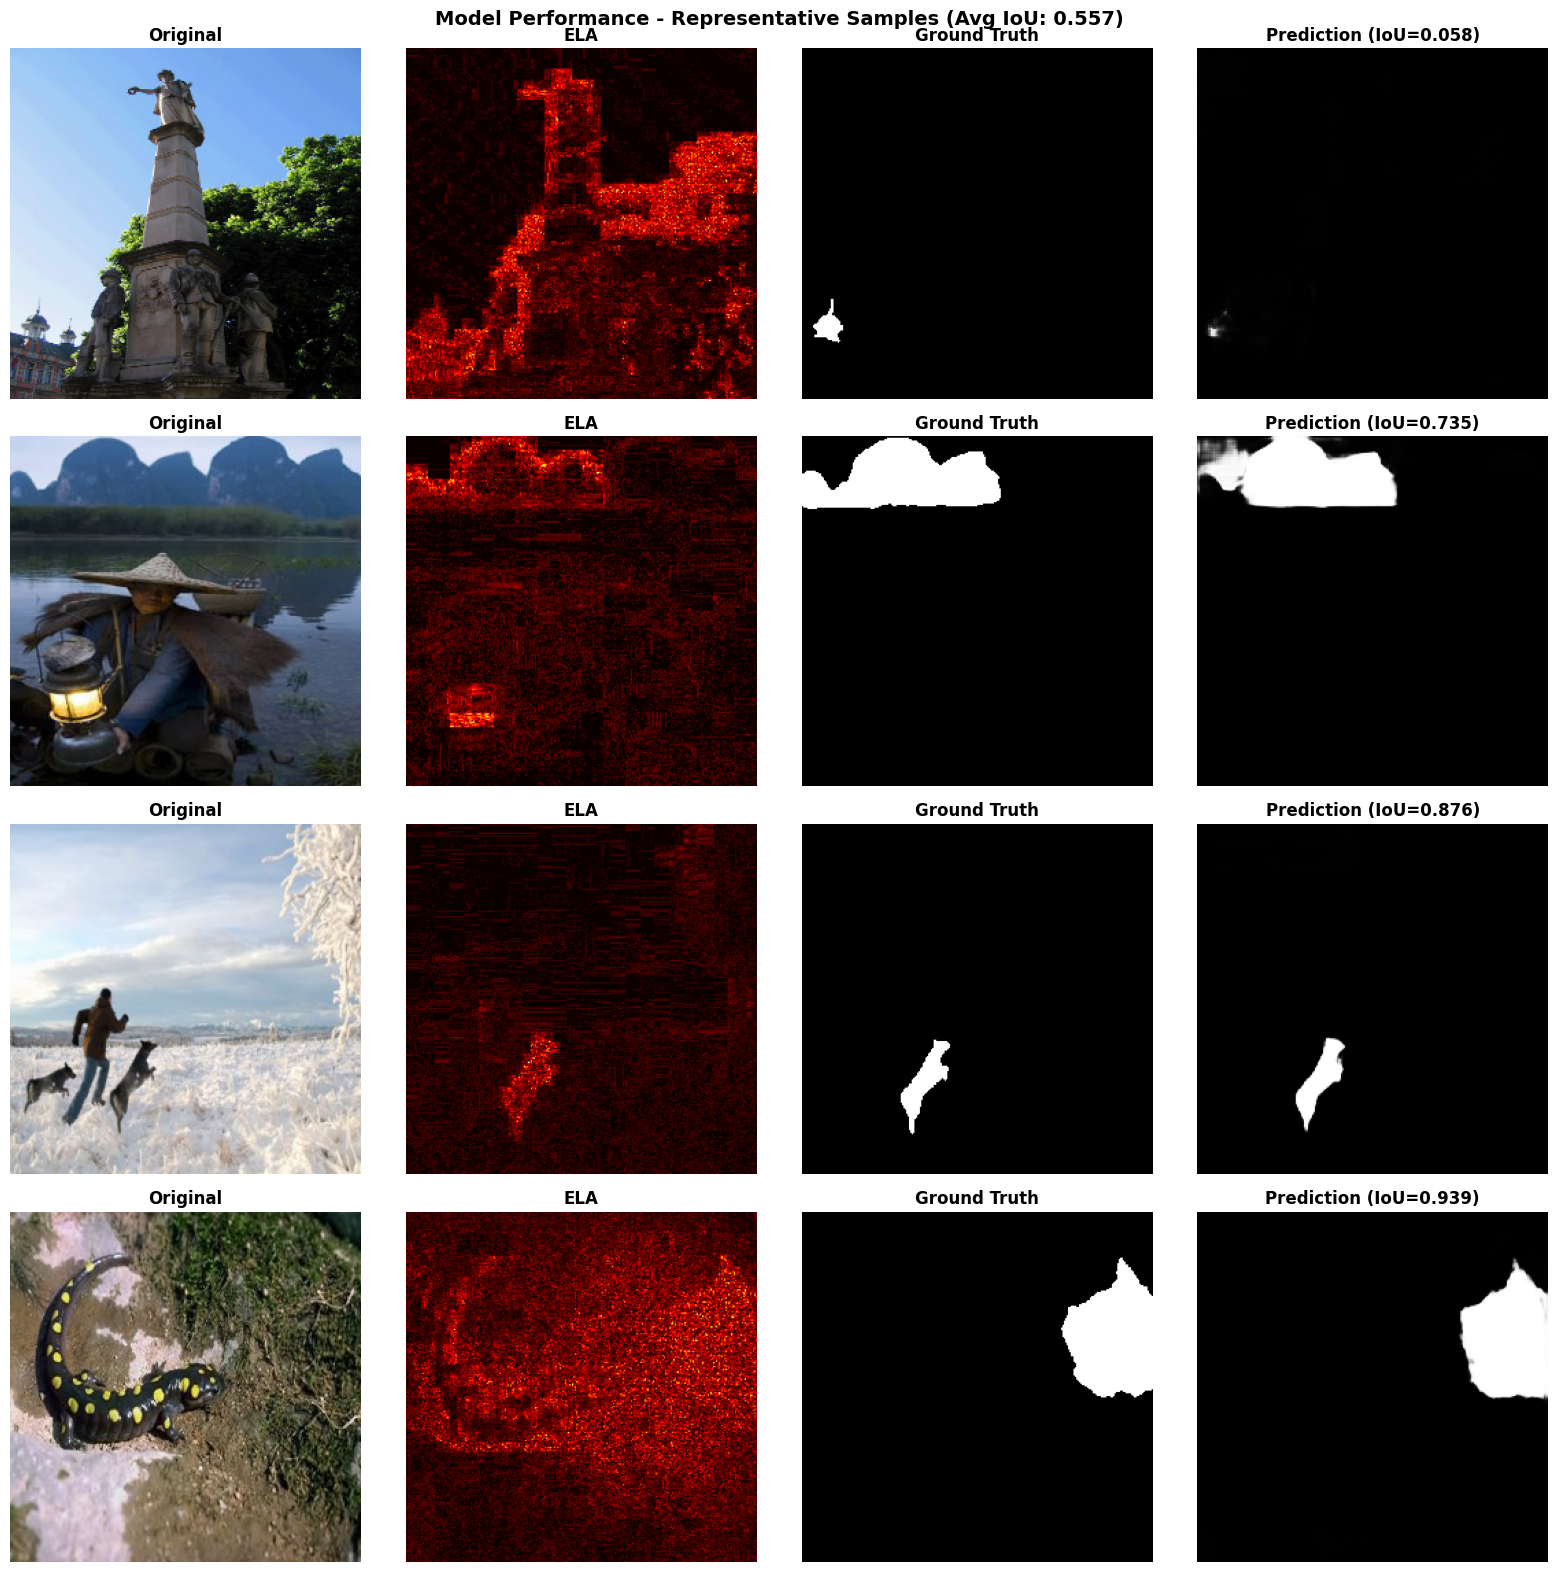


IoU Distribution:
  Mean: 0.557
  Median: 0.733
  25th percentile: 0.058
  75th percentile: 0.875
  Best: 0.994
  Worst: 0.000


In [53]:
# =============================================================================
# Cell 10: Visualisation - Select Representative Samples
# =============================================================================

def visualise_best_predictions(model, test_loader, device, num_samples=4):
    """
    Select and visualise samples that represent the model's actual performance
    """
    model.eval()
    
    # Collect all predictions and calculate IoUs
    all_samples = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data_device = data.to(device)
            outputs = model(data_device)
            predictions = torch.sigmoid(outputs)
            
            # Calculate IoU for each sample
            for i in range(data.shape[0]):
                metrics = calculate_metrics(
                    predictions[i:i+1].cpu(), 
                    targets[i:i+1]
                )
                
                all_samples.append({
                    'data': data[i],
                    'target': targets[i],
                    'prediction': predictions[i].cpu(),
                    'iou': metrics['iou']
                })
    
    # Sort by IoU to find representative samples
    all_samples.sort(key=lambda x: x['iou'])
    
    # Select samples at different percentiles to show range
    total = len(all_samples)
    indices = [
        int(total * 0.25),  # 25th percentile (lower performance)
        int(total * 0.50),  # 50th percentile (median)
        int(total * 0.75),  # 75th percentile (good performance)
        int(total * 0.90),  # 90th percentile (best performance)
    ]
    
    selected_samples = [all_samples[i] for i in indices[:num_samples]]
    
    # Plot
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample in enumerate(selected_samples):
        # Extract RGB
        rgb = sample['data'][:3].numpy()
        rgb = rgb * np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1) + \
              np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        rgb = np.clip(rgb.transpose(1, 2, 0), 0, 1)
        
        # ELA
        ela = sample['data'][3].numpy()
        
        # Ground truth
        gt = sample['target'][0].numpy()
        
        # Prediction
        pred = sample['prediction'][0].numpy()
        
        # Display
        axes[idx, 0].imshow(rgb)
        axes[idx, 0].set_title('Original', fontsize=12, fontweight='bold')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(ela, cmap='hot')
        axes[idx, 1].set_title('ELA', fontsize=12, fontweight='bold')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(gt, cmap='gray')
        axes[idx, 2].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(pred, cmap='gray')
        axes[idx, 3].set_title(f'Prediction (IoU={sample["iou"]:.3f})', 
                               fontsize=12, fontweight='bold')
        axes[idx, 3].axis('off')
    
    plt.suptitle(f'Model Performance - Representative Samples (Avg IoU: {np.mean([s["iou"] for s in all_samples]):.3f})',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('representative_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    ious = [s['iou'] for s in all_samples]
    print("\nIoU Distribution:")
    print(f"  Mean: {np.mean(ious):.3f}")
    print(f"  Median: {np.median(ious):.3f}")
    print(f"  25th percentile: {np.percentile(ious, 25):.3f}")
    print(f"  75th percentile: {np.percentile(ious, 75):.3f}")
    print(f"  Best: {np.max(ious):.3f}")
    print(f"  Worst: {np.min(ious):.3f}")


visualise_best_predictions(model, test_loader, DEVICE, num_samples=4)

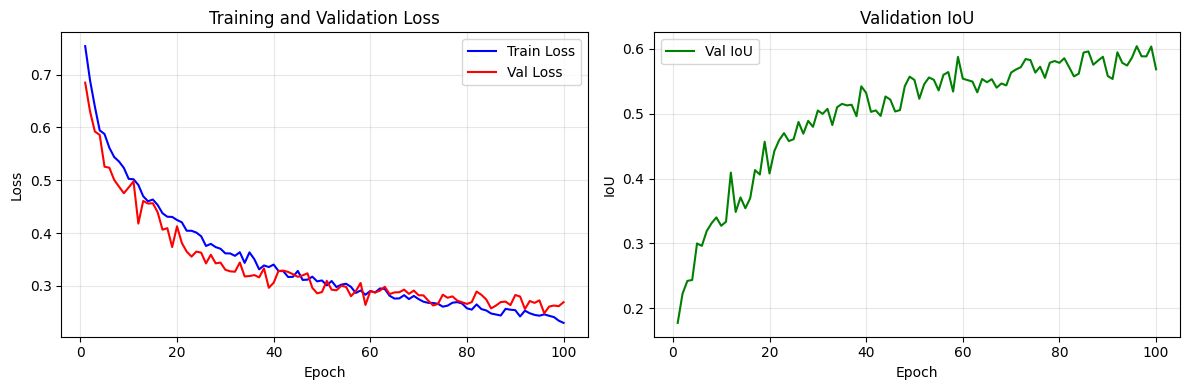

In [54]:
# =============================================================================
# Cell 11: Plot Training History
# =============================================================================

if history['train_loss']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs, history['val_iou'], 'g-', label='Val IoU')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('IoU')
    ax2.set_title('Validation IoU')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [55]:
# =============================================================================
# Cell 12: Save Final Model
# =============================================================================

# Save complete model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'metrics': avg_metrics,
    'history': history
}

torch.save(checkpoint, 'forgery_detection_final.pth')
print(f"\nModel saved as 'forgery_detection_final.pth'")
print(f"File size: {os.path.getsize('forgery_detection_final.pth') / 1024 / 1024:.2f} MB")


Model saved as 'forgery_detection_final.pth'
File size: 118.50 MB
